# Lemmatized tvec using LogReg

In [33]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import json

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [36]:
from sklearn.pipeline import Pipeline

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
from nltk.stem import WordNetLemmatizer

In [40]:
# load df's
bb = pd.read_csv('../df_csv/bbfinal.csv')
bcs = pd.read_csv('../df_csv/bcsfinal.csv')

In [41]:
# check head
bb.head()

,author,created_utc,downs,num_comments,score,selftext,title,ups,subreddit,all_text
0,Ashutosh1947,2019-07-07 12:03:45,0,6,188,NaN,Los pollos shifts towards noodles from chicken,188,1,Los pollos shifts towards noodles from chicken
1,Rykedan,2019-07-06 17:44:03,0,25,1875,NaN,Pretty cool Thought you guys would appreciated...,1875,1,Pretty cool Thought you guys would appreciated...
2,Burnnoticelover,2019-07-07 03:01:46,0,17,269,NaN,The ending we got was perfect but it would hav...,269,1,The ending we got was perfect but it would hav...
3,spillthetea13,2019-07-07 13:24:13,0,2,21,Its like a kitchen nightmare episode but inste...,Breaking bad movie idea,21,1,Breaking bad movie ideaIts like a kitchen nigh...
4,pretentiousiscool,2019-07-07 15:50:31,0,0,10,NaN,lmao,10,1,lmao


In [42]:
# check head
bcs.head()

,author,created_utc,downs,num_comments,score,selftext,title,ups,subreddit,all_text
0,skinkbaa,2018-11-11 07:52:32,0,251,296,A few people requested this thread Feel fre...,Breaking Bad Movie Prediction Thread,296,0,Breaking Bad Movie Prediction ThreadA few pe...
1,skinkbaa,2019-05-05 22:23:21,0,98,88,What do you think will happen next season Feel...,Better Call Saul Season 5 Official Predictio...,88,0,Better Call Saul Season 5 Official Predictio...
2,snarfje,2019-07-07 09:20:38,0,36,944,NaN,Saw this gentlemen on a foodtruck festival i...,944,0,Saw this gentlemen on a foodtruck festival i...
3,RrentTreznor,2019-07-06 21:50:07,0,35,404,NaN,Cherished family heirloom finally has made its...,404,0,Cherished family heirloom finally has made its...
4,Ashutosh1947,2019-07-07 16:12:49,0,0,1,NaN,Oc,1,0,Oc


In [43]:
# combine df's into one large one
data = pd.concat(objs=[bcs[['all_text', 'subreddit', 'num_comments', 'score']], bb[['all_text', 'subreddit', 'num_comments', 'score']]], ignore_index=True)

In [44]:
# check number of 1's and 0's in target
data['subreddit'].value_counts(normalize=True)

1    0.513871
0    0.486129
Name: subreddit, dtype: float64

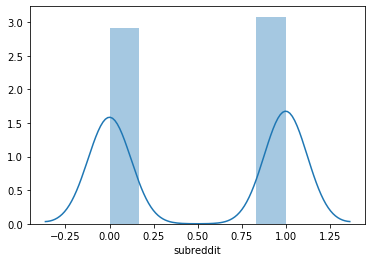

In [45]:
# dist of 1's and 0's
sns.distplot(data['subreddit'])

In [68]:
# remove numbers from text
# data['all_text'] = data['all_text'].str.replace('\d+', '')

In [17]:
# set X and y variables
X = data['all_text']
y = data['subreddit']

In [57]:
from nltk.corpus import stopwords

In [18]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [115]:
# function to split posts into words, then lemmatize
# adopted from lecture

def text_lem(text):
    # Tokenize text.
    tokens = text.split()
    
    # Instantiate stemmer.
    lemmatizer = WordNetLemmatizer()
    
    # convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # Lemmatize words.
    lem_words = [lemmatizer.lemmatize(i) for i in tokens]
    
     # 5. Remove stop words.
    lem_words = [w for w in lem_words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lem_words))

In [119]:
# create new column with lemmatized text
data['lem_posts'] = data['all_text'].apply(text_lem)

In [127]:
# set X and y variables
X = data['lem_posts']
y = data['subreddit']

In [128]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [129]:
# pipeline

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [130]:
# evaluate on unseen data
cross_val_score(pipe, X_train, y_train, cv=5).mean()

/Users/mariosanchez/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7765765765765766

In [131]:
# gridsearch for best parameters

pipe_params = {
    'tvec__max_features':[3000, 3500, 4000],
    'tvec__min_df':[2, 3],
    'tvec__max_df':[.9, .95],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__stop_words':[None, 'english'],
    'lr__penalty':['l1','l2'],
    'lr__C':[.1, 1, 10],
    
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/Users/mariosanchez/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.790990990990991


{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'lr__C': 0.1,
 'lr__penalty': 'l2'}

In [132]:
# accuracy score on train data
gs.score(X_train, y_train)

0.9054054054054054

In [133]:
# accuracy score on test data
gs.score(X_test, y_test)

0.7710084033613446

## Fit model with optimal parameters

In [134]:
tvec = TfidfVectorizer(max_df= 0.9,
 max_features= 3000,
 min_df= 2,
 ngram_range= (1, 1),
 stop_words= None)

In [135]:
X_train_vec = tvec.fit_transform(X_train)
X_test_vec = tvec.transform(X_test)

In [136]:
lr = LogisticRegression(
    C=0.1,
    penalty='l2'
)

In [137]:
lr.fit(X_train_vec, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [138]:
# get predictions
predictions = lr.predict(X_test_vec)

In [139]:
# create confusion matrix
cm = confusion_matrix(y_test, predictions)

In [140]:
# print report
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74       188
           1       0.87      0.74      0.80       288

    accuracy                           0.77       476
   macro avg       0.77      0.78      0.77       476
weighted avg       0.79      0.77      0.77       476



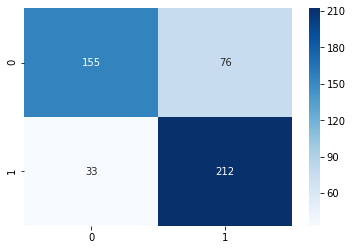

In [141]:
# adapted from stackoverflow
# plot confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g'); #annot=True to annotate cells

In [142]:
# create a list of word counts to plot
train_list = list(zip(tvec.get_feature_names(), X_train_vec.toarray().sum(axis=0)))

In [143]:
# convert to dataframe
train_list = pd.DataFrame(train_list, columns=['word', 'word_count'])

In [144]:
train_list

,word,word_count
0,000,2
1,10,19
2,100,3
3,11,5
4,13,4
5,15,3
6,1997,4
7,2013,4
8,2019,6
9,2020,5


In [145]:
# get only the 15 most frequent words
top_15 = train_list.sort_values(by='word_count', ascending=False).head(15)

In [146]:
# get only the 15 least frequent words
bottom_15 = train_list.sort_values(by='word_count').head(15)

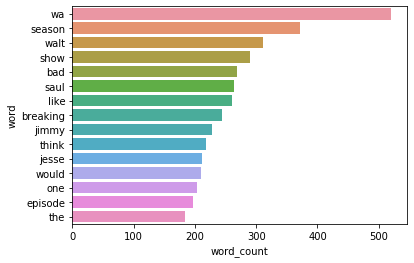

In [147]:
sns.barplot('word_count', 'word', data=top_15, orient='h')

## Tree and Bag

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [90]:
# Instantiate `DecisionTreeClassifier` object.
tree = DecisionTreeClassifier()

In [91]:
cross_val_score(tree, X_train_vec, y_train, cv=5).mean()

0.7367423893449122

In [103]:
tree.fit(X_train_vec, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [104]:
tree.score(X_train_vec, y_train)

0.9882253994953742

In [105]:
tree.score(X_test_vec, y_test)

0.7355163727959698

In [92]:
bag = BaggingClassifier()

In [93]:
cross_val_score(bag, X_train_vec, y_train, cv=5).mean()

0.7577545164562303

In [106]:
bag.fit(X_train_vec, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [107]:
bag.score(X_train_vec, y_train)

0.9714045416316233

In [108]:
bag.score(X_test_vec, y_test)

0.7455919395465995

## Pipe 2

In [110]:
# pipeline

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [113]:
cross_val_score(pipe, X_train, y_train, cv=5).mean()

/Users/mariosanchez/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7871773040554604

In [115]:
pipe_params = {
    'tvec__max_features':[2500, 3000, 3500],
    'tvec__min_df':[2, 3],
    'tvec__max_df':[.9, .95],
    'tvec__ngram_range':[(1,1),(1,2)],
    'tvec__stop_words':[None, 'english'],
    'lr__penalty':['l1','l2'],
    'lr__C':[.1, 1, 10],
    
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/Users/mariosanchez/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mariosanchez/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7922624053826746


{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.9,
 'tvec__max_features': 2500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [116]:
gs.score(X_test, y_test)

0.7556675062972292

In [117]:
gs.score(X_train, y_train)

0.9335576114381834

In [236]:
tvec = TfidfVectorizer(
    max_df= 0.9,
    max_features= 2500,
    min_df= 2,
    ngram_range= (1, 1),
    stop_words= 'english'
)

In [237]:
X_train_tvec = tvec.fit_transform(X_train).toarray()

In [238]:
X_test_tvec = tvec.transform(X_test).toarray()

In [239]:
lr = LogisticRegression(
    C= 1,
    penalty= 'l2'
)

In [240]:
lr.fit(X_train_tvec, y_train )

/Users/mariosanchez/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [241]:
lr.score(X_train_tvec, y_train)

0.9396396396396396

In [242]:
lr.score(X_test_tvec, y_test)

0.7584033613445378

In [243]:
preds = lr.predict(X_test_tvec)

In [244]:
cm = confusion_matrix(y_test, preds)

array([[158,  73],
       [ 42, 203]])

In [ ]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
